In [96]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Load the training and testing data

In [ ]:
try:
    train_df = pd.read_csv('Dataset.txt', sep='\t', index_col = 'Index')
    test_df = pd.read_csv('Dataset_test.txt', sep='\t', index_col = 'Index')
except FileNotFoundError as e:
    print(f"File not found: {e}")
    exit(1)

# First 5 records
print(train_df.head())
print(test_df.head())

# Convert date features to numeric timestamps first
for df in [train_df, test_df]:
    df['F15'] = pd.to_datetime(df['F15'])
    df['F16'] = pd.to_datetime(df['F16'])

# The difference in days between the two dates could be a very important feature
for df in [train_df, test_df]:
    df['date_diff_days'] = (df['F16'] - df['F15']).dt.days
    # extract the year and month, which might show trends.
    df['F15_year'] = df['F15'].dt.year
    df['F15_month'] = df['F15'].dt.month
    df['F16_year'] = df['F16'].dt.year
    df['F16_month'] = df['F16'].dt.month
    # capture weekly patterns (Monday=0, Sunday=6)
    df['F15_dayofweek'] = df['F15'].dt.dayofweek
    df['F16_dayofweek'] = df['F16'].dt.dayofweek


# Remove the original date columns 
train_df = train_df.drop(['F15', 'F16'], axis=1)
test_df = test_df.drop(['F15', 'F16'], axis=1)

print("\nfirst 5 rows of data after date conversion:")
print(train_df.head())
print(test_df.head())

             F1        F2        F3        F4    F5    F6    F7    F8    F9  \
Index                                                                         
1      0.224506  0.500340  0.489860  0.902413  7934 -6970 -5714  9982 -5697   
2      0.321128  0.281119  0.907283  0.772159 -8238  1219  1663  1287 -3658   
3      0.893441  0.622005  0.998776  0.098386  8540  5266 -9377 -3504 -4511   
4      0.320641  0.957234  0.346000  0.646479 -7772  -383  9681 -8661  3474   
5      0.475961  0.623008  0.544988  0.159709  1571 -8039 -7961 -2385  4407   

              F10  ...         F14        F15         F16  F17 F18  F19  F20  \
Index              ...                                                         
1      4227810299  ... -3433637453  10/4/1986    9/6/1992    2   1  706  305   
2     -1146724819  ...   609277486  2/24/1979    1/5/1983    1   1  423  206   
3      5947184989  ... -8977995005  1/12/1989  11/22/1986    2   1  703  315   
4     -5724795826  ...  4868760308  2/18/1982 

### Check for missing values in training data

In [ ]:

print("Missing values in training data:")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0]) 

# --- Check for missing values in test data 
print("\nMissing values in test data:")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

Missing values in training data:
Series([], dtype: int64)

Missing values in test data:
Series([], dtype: int64)


### Check Class Balance

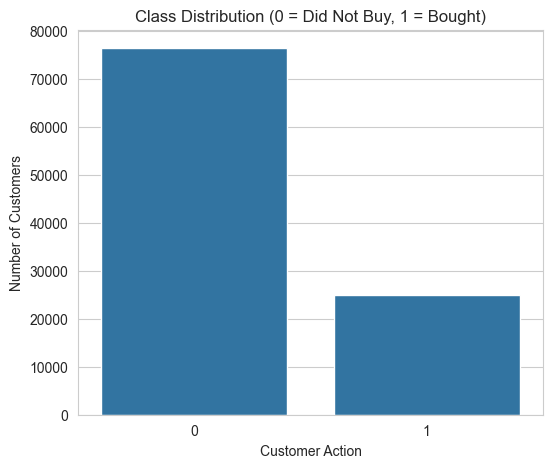

In [ ]:

plt.figure(figsize=(6, 5))
sns.countplot(x='C', data=train_df)
plt.title('Class Distribution (0 = Did Not Buy, 1 = Bought)')
plt.ylabel('Number of Customers')
plt.xlabel('Customer Action')
plt.show()

### box plot of all features to detect the outliers

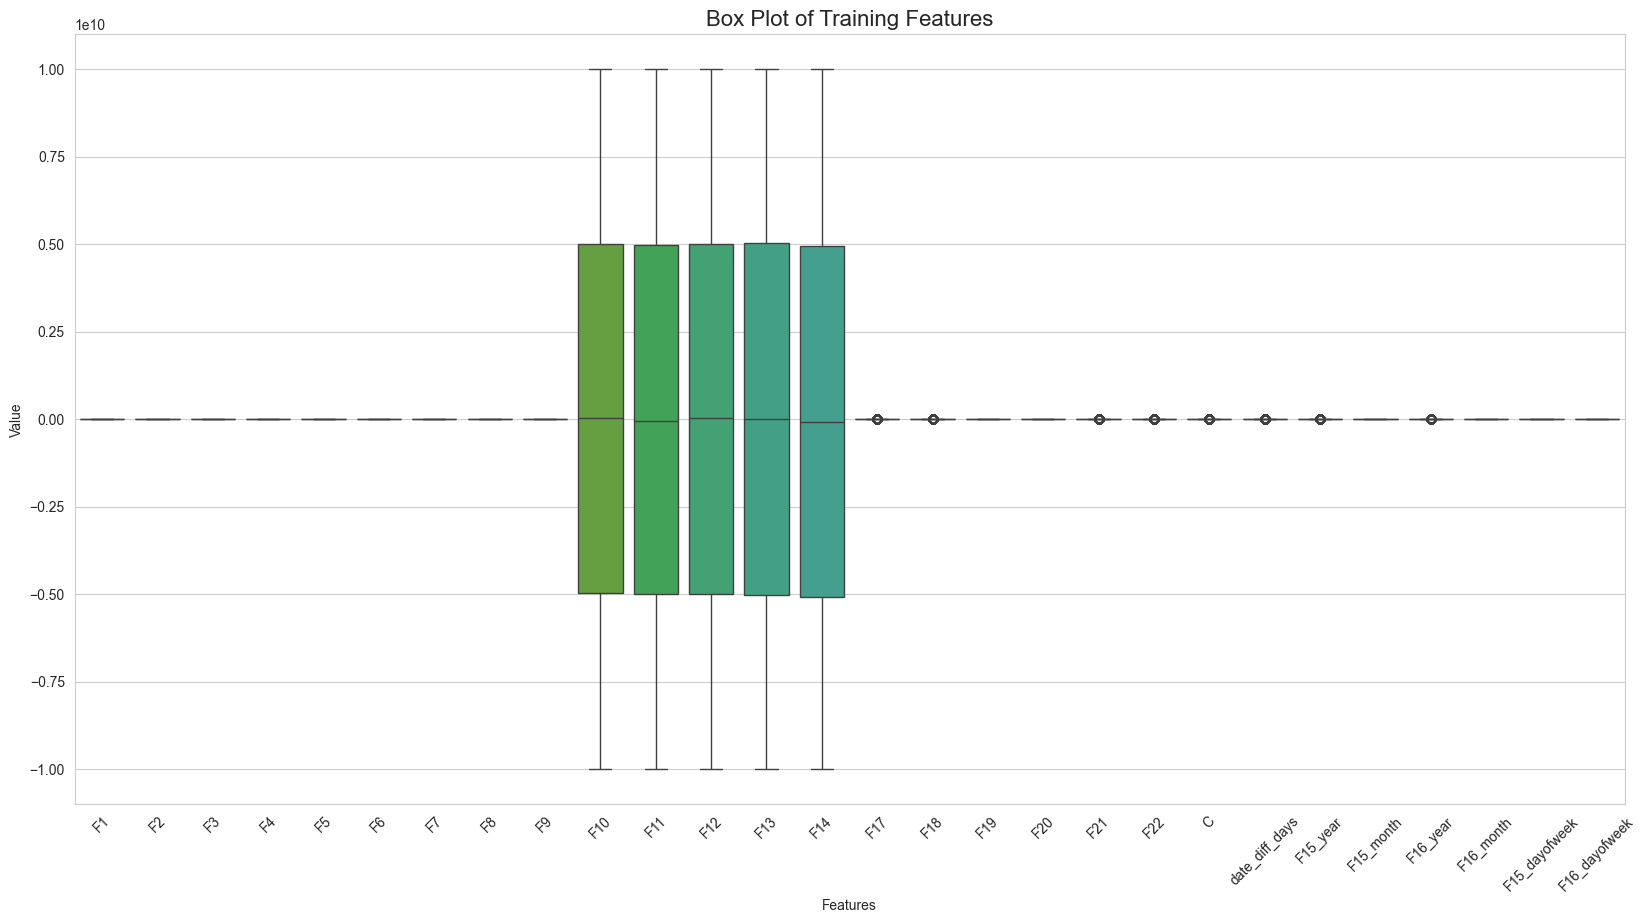

In [ ]:

plt.figure(figsize=(20, 10)) 
sns.boxplot(data=train_df)
plt.xticks(rotation=45) 
plt.title('Box Plot of Training Features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Value')
plt.show() 

### Correlation matrix

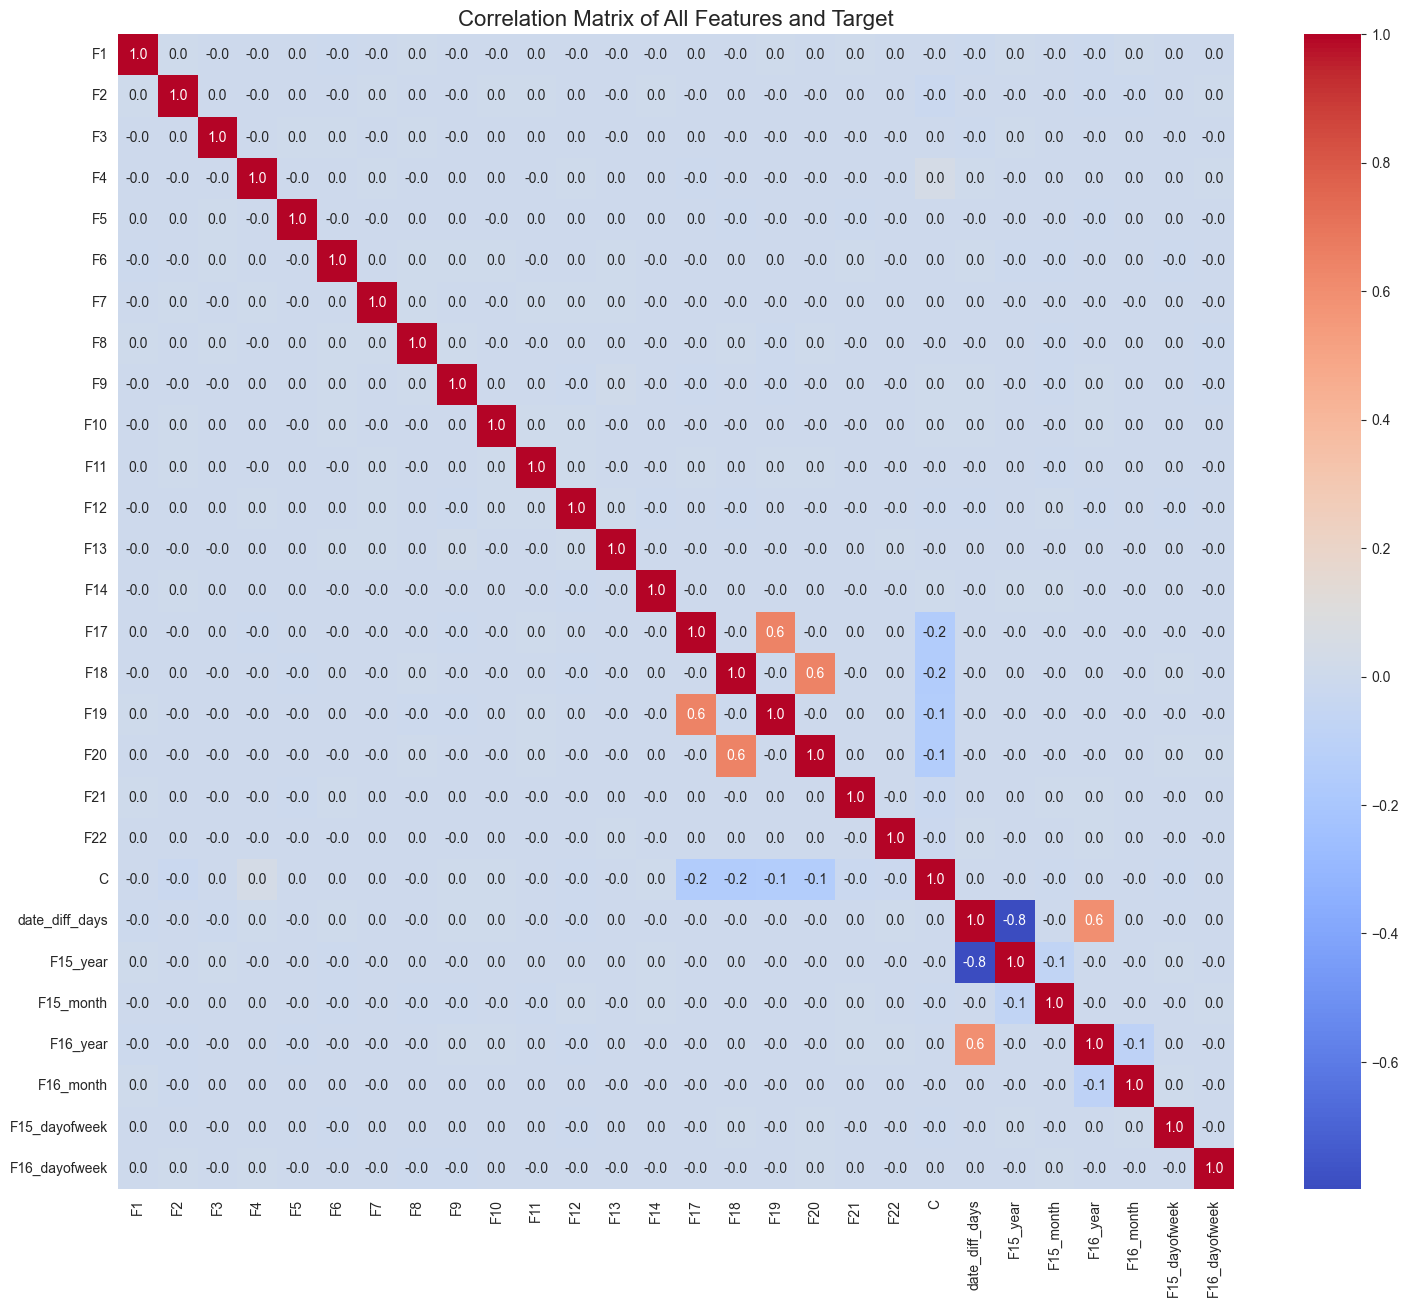

In [ ]:
correlation_matrix = train_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 15))

# Draw the heatmap
sns.heatmap(correlation_matrix, 
            annot=True,      
            fmt='.1f',       # Format the numbers to one decimal place
            cmap='coolwarm') 

plt.title('Correlation Matrix of All Features and Target', fontsize=16)
plt.show()

In [78]:
# Remove features that are highly correlated with each other (threshold = 0.8)
corr_matrix = train_df.drop(columns=['C']).corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

train_df.drop(columns=high_corr_features, inplace=True)
test_df.drop(columns=high_corr_features, inplace=True)

print(f"Removed {len(high_corr_features)} highly correlated features.")

Removed 0 highly correlated features.


In [75]:
# separate the target variable 'C' from the features 
# 'X' will hold all the features, 'y' will hold the target 
X = train_df.drop('C', axis=1)
y = train_df['C']

### Training the Random Forest model

Training model....
Top features from Random Forest: ['F20', 'F19', 'F14', 'F13', 'F2', 'F4', 'F10', 'F8', 'F1', 'F11', 'F12', 'F9', 'F3', 'F5', 'F7']


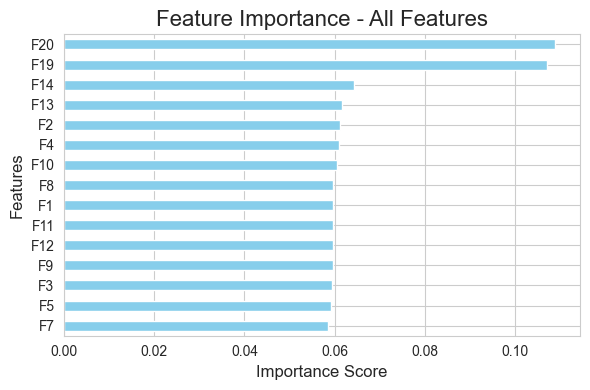

Data prepared using Random Forest-selected features.


In [ ]:

rf = RandomForestClassifier(random_state=42)
print("Training model....")
rf.fit(X, y)

# Select top 15 features by importance
rf_feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
top_rf_features = rf_feature_importances.sort_values(ascending=False).head(15).index.tolist()
print(f"Top features from Random Forest: {top_rf_features}")

# Visualize all features (sorted by importance)
plt.figure(figsize=(6, 4))
rf_feature_importances.sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title("Feature Importance - All Features", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# Keep only top features
X = X[top_rf_features]
X_test = test_df[top_rf_features]
print("Data prepared using Random Forest-selected features.")

### Split the data into training and validation sets

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data successfully split into training and validation sets.")

Data successfully split into training and validation sets.


### Plot class distribution

/var/folders/kc/c_87cnx52j3fl79n_jdvy5100000gn/T/ipykernel_23924/2341108059.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="coolwarm")


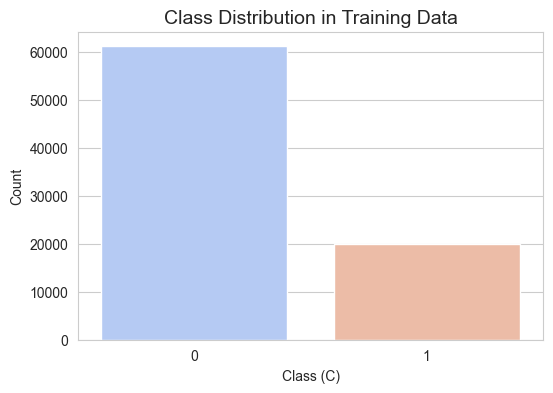

In [ ]:

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette="coolwarm")
plt.title("Class Distribution in Training Data", fontsize=14)
plt.xlabel("Class (C)")
plt.ylabel("Count")
plt.show()

### Scale the features

In [ ]:
 
# This transforms the data so that all features have a similar scale.
# This helps the model learn more effectively.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("Features scaled.")

Features scaled.


### Handling Class Imbalance

In [ ]:
 
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Calculated scale_pos_weight for imbalance: {ratio:.2f}")

Calculated scale_pos_weight for imbalance: 3.08


### Training the XGBoost Model on Random Forest-selected features

In [ ]:

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=ratio,
    random_state=42
)
print("Training the XGBoost model on Random Forest-selected features...")
xgb_model.fit(X_train_scaled, y_train)
print("XGBoost model training complete.")

Training the XGBoost model on Random Forest-selected features...
XGBoost model training complete.


### Evaluating the Model

In [95]:
# Training Accuracy
train_predictions = xgb_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"XGBoost Accuracy on Training Data: {train_accuracy:.4f}")

# Classification Report
print("-" * 50)
print("Training Classification Report:")
print(classification_report(y_train, train_predictions))
print("-" * 50)


XGBoost Accuracy on Training Data: 0.7142
--------------------------------------------------
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     61082
           1       0.46      0.93      0.62     19862

    accuracy                           0.71     80944
   macro avg       0.71      0.79      0.69     80944
weighted avg       0.84      0.71      0.73     80944

--------------------------------------------------


XGBoost Accuracy on Validation Data: 0.6153
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.58      0.69     15271
           1       0.36      0.73      0.48      4965

    accuracy                           0.62     20236
   macro avg       0.61      0.65      0.59     20236
weighted avg       0.74      0.62      0.64     20236

--------------------------------------------------


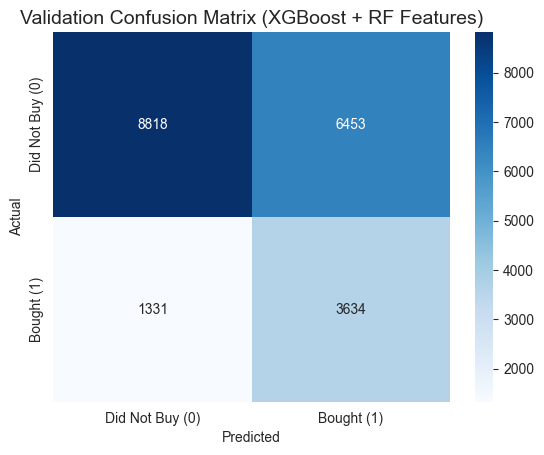

In [ ]:
# Validation Accuracy
val_predictions = xgb_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, val_predictions)
print(f"XGBoost Accuracy on Validation Data: {accuracy:.4f}")
print("-" * 50)
print("Classification Report:")
print(classification_report(y_val, val_predictions))
print("-" * 50)

# Confusion Matrix
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Buy (0)', 'Bought (1)'],
            yticklabels=['Did Not Buy (0)', 'Bought (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix (XGBoost + RF Features)', fontsize=14)
plt.show()


--- AUC-ROC Evaluation ---
Validation AUC-ROC Score: 0.7070


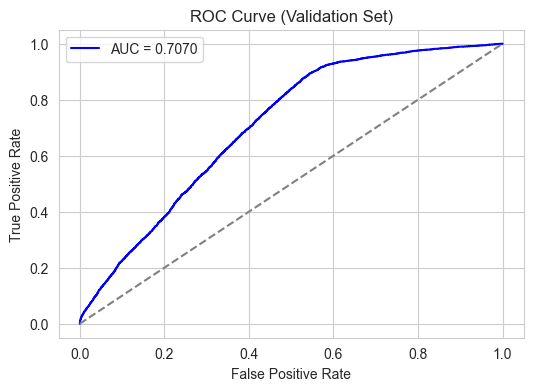

In [97]:
print("\n--- AUC-ROC Evaluation ---")
val_pred_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Calculate AUC score
auc = roc_auc_score(y_val, val_pred_proba)
print(f"Validation AUC-ROC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, val_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

In [94]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Train final XGBoost model on all data
ratio = y.value_counts()[0] / y.value_counts()[1]
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=ratio,
    random_state=42
)

print("Training final model on all data...")
model.fit(X_scaled, y)

# Predictions on training data
train_preds = model.predict(X_scaled)
pd.DataFrame({"Class": train_preds}, index=X.index).to_csv("training_predictions.txt", sep="\t")
print("training_predictions.txt saved.")

# Predictions on testing data
test_preds = model.predict(X_test_scaled)
pd.DataFrame({"Class": test_preds}, index=X_test.index).to_csv("test_predictions.txt", sep="\t")
print("test_predictions.txt saved.")

Training final model on all data...
training_predictions.txt saved.
test_predictions.txt saved.
